In [1]:
import json
import requests
import pandas as pd
import numpy as np
import glob

rd = pd.read_excel('./Resources/combined_phecodex_list.xlsx')
cd = rd.loc[rd['Type'] == 'Common']

from statsmodels.stats.proportion import proportion_confint
import seaborn as sns
from matplotlib import pyplot as plt

# Optional plotting function
if True:
    import re
    import os
    import matplotlib
    import matplotlib.font_manager as font_manager

    font_path = '/sc/arion/projects/GENECAD/Robert/arial.ttf'
    assert os.path.exists(font_path)
    font_manager.fontManager.addfont(font_path)
    prop = font_manager.FontProperties(fname=font_path)

    matplotlib.rc('font', family='sans-serif')
    matplotlib.rcParams.update({
        'font.size': 12,
        'font.sans-serif': prop.get_name(),
        'axes.titlesize': 12
    })


## Create input

In [6]:
hp = pd.read_pickle('./Resources/hpo_phecodex_map.pkl')[['phecode','id']]
hp = hp.rename({'id':'code'},axis=1)
hp = hp[['code','phecode']]
hp = hp.loc[hp['phecode'].isin(rd['phecode'])]
hp['code'] = hp['code'].str.replace('_',':')

map = pd.read_pickle('./OT_Final/diseases_cleaned.pkl').dropna()
a = map.loc[map['id'].str.contains('HP')]
a = a[['id','phecode']].rename({'id':'code'},axis=1)
a['code'] = a['code'].str.replace('_',':')
b = map.loc[map['terminology'].str.contains('HP')]
b['code'] = 'HP:' + b['code']
map = pd.concat([a,b,hp]).drop_duplicates()

pred = pd.read_pickle('./GPS/Main/Predictions/apc_predictions_ot_mantis_cc.pkl').sort_values('prediction', ascending=False)
pred = pred.merge(rd[['phecode','phecode_string']])

alldata = pd.read_pickle('./Final/ml_input.pkl')
alldata = alldata[['gene','phecode','clin_ot','hgmd','gwas_credible_sets','gene_burden','mantis',
                   'cc_common_max_p','cc_rare_max_p','cc_rare_burden_max_p','cc_ultrarare_max_p']]
alldata = alldata.loc[(alldata['cc_common_max_p'] > -np.log10(5e-8)) | (alldata['cc_rare_max_p'] > -np.log10(4.3e-7))
                        | (alldata['cc_rare_burden_max_p'] > -np.log10(0.05/18500)) | (alldata['cc_ultrarare_max_p'] > -np.log10(0.05/18500))]

cutoff = 0.0368
new = pd.concat([pred.loc[pred['prediction'] >= cutoff][['phecode','gene']], 
                 pred.loc[pred['prediction'] < cutoff].sample(20000, random_state=42)[['phecode','gene']],
                 alldata[['phecode','gene']]]).drop_duplicates()
new = new.merge(hp)[['code','gene']].drop_duplicates().sort_values(['code','gene'])
new['id'] = new['code'] + new['gene']
new.to_csv('./AMELIE/input.csv', index=False)


/var/folders/bx/lbpmpm7d4z1dn9ql0yg80hc80000gn/T/ipykernel_30618/2162324788.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  b['code'] = 'HP:' + b['code']


## Run jobs

In [ ]:
input = pd.read_csv('./AMELIE/input.csv')

for hp_code in input['code'].unique():
    try:
        temp = input.loc[input['code'] == hp_code]

        url = 'https://amelie.stanford.edu/api/gene_list_api/'

        response = requests.post(
            url,
            verify=False,
            data={'patientName': 'Example patient',
                    'phenotypes': ','.join([hp_code]),
                    'genes': ','.join(temp['gene'])})

        data = response.json()

        records = []

        for gene, publications in data:
            for pub in publications:
                pubmed_id, score = pub
                records.append([gene, hp_code, pubmed_id, score])

        df = pd.DataFrame(records, columns=['gene', 'phenotype', 'pubmed id', 'score'])
        df.to_csv(f'./AMELIE/Temp/amelie_output_{hp_code}.csv', index=False)
    except:
        print("Failure")

In [ ]:
# Retry only the jobs where the expected output file is missing

# Find missing phenotype codes
missing_codes = []
for hp_code in input['code'].unique():
    out_path = f'./AMELIE/Temp/amelie_output_{hp_code}.csv'
    try:
        with open(out_path, 'rb'):
            pass  # file exists
    except FileNotFoundError:
        missing_codes.append(hp_code)

print(f"Identified {len(missing_codes)} missing jobs.")

# Retry each missing job
still_missing = []
for hp_code in missing_codes:
    try:
        temp = input.loc[input['code'] == hp_code]

        url = 'https://amelie.stanford.edu/api/gene_list_api/'
        response = requests.post(
            url,
            verify=False,
            timeout=60,
            data={
                'patientName': 'Example patient',
                'phenotypes': ','.join([hp_code]),
                'genes': ','.join([str(g) for g in temp['gene'].dropna().tolist()])
            }
        )

        data = response.json()  # expected iterable of (gene, publications)

        records = []
        for gene, publications in data:
            for pub in publications:
                pubmed_id, score = pub
                records.append([gene, hp_code, pubmed_id, score])

        df = pd.DataFrame(records, columns=['gene', 'phenotype', 'pubmed id', 'score'])
        df.to_csv(f'./AMELIE/Temp/amelie_output_{hp_code}.csv', index=False)
        print(f"Completed: {hp_code} with {len(records)} records.")
    except Exception as e:
        print(f"Retry failed for {hp_code}: {e}")
        still_missing.append(hp_code)

if still_missing:
    print(f"Still missing ({len(still_missing)}): {', '.join(map(str, still_missing))}")
else:
    print("All missing jobs completed successfully.")

In [10]:
csv_files = glob.glob('./AMELIE/Temp/amelie*.csv')
df_combined = pd.concat([pd.read_csv(file) for file in csv_files])
df_combined.to_pickle('./AMELIE/amelie_output.pkl')


## Process output

In [11]:
ao = pd.read_pickle('./AMELIE/amelie_output.pkl').drop_duplicates().rename({'phenotype':'code'},axis=1)
i = pd.read_csv('./AMELIE/input.csv').drop_duplicates().merge(map[['phecode','code']].drop_duplicates())[['gene','phecode']].drop_duplicates()

ao = ao.merge(map[['phecode','code']].drop_duplicates())
a = ao.groupby(['gene','phecode'])['score'].max().reset_index()
b = ao.groupby(['gene','phecode'])['pubmed id'].nunique().reset_index()
ao = a.merge(b, how='left')
ao = i.merge(ao, how='left')
ao = ao.fillna(0)
ao.to_pickle('./AMELIE/amelie_output_aggregated.pkl')


In [2]:
ao = pd.read_pickle('./AMELIE/amelie_output_aggregated.pkl')
ao['id'] = ao['phecode'] + ':' + ao['gene']
ao = ao[['id','score']].rename({'score':'amelie'},axis=1)

pred = pd.read_pickle('./GPS/Main/Predictions/apc_predictions_ot_mantis_cc.pkl').sort_values('prediction', ascending=False)
ap = pred[['id','prediction']].merge(ao)
ap['amelie_binary'] = 0
ap.loc[ap['amelie'] > 0, 'amelie_binary'] = 1
ap['amelie_binary_strong'] = 0
ap.loc[ap['amelie'] > 50, 'amelie_binary_strong'] = 1

cutoff = 0.036805
print(ap.loc[ap['prediction'] > cutoff]['amelie_binary'].mean())
print(ap.loc[ap['prediction'] > cutoff]['amelie_binary_strong'].mean())


0.6898238747553816
0.39628180039138944


In [7]:
pred.sort_values('prediction')[:round(0.5*len(pred))]

,id,prediction,gene,phecode,indication,phase,xscore
2567150,NS_343.6:SLC11A2,0.001622,SLC11A2,NS_343.6,0,0.0,0.0
106230,BI_179.6:PPARGC1B,0.001645,PPARGC1B,BI_179.6,0,0.0,0.0
1016731,GE_971.14:CD248,0.001667,CD248,GE_971.14,0,0.0,0.0
978709,GE_971.11:C4B,0.001681,C4B,GE_971.11,0,0.0,0.0
602511,DE_666.4:ASIC3,0.001701,ASIC3,DE_666.4,0,0.0,0.0
...,...,...,...,...,...,...,...
1950355,MS_700.3:TNFSF12-TNFSF13,0.004512,TNFSF12-TNFSF13,MS_700.3,0,0.0,0.0
1073795,GE_972.9:CLDN24,0.004512,CLDN24,GE_972.9,0,0.0,0.0
1988840,MS_700.43:VPS54,0.004512,VPS54,MS_700.43,0,0.0,0.0
1018890,GE_971.14:EFCAB13,0.004512,EFCAB13,GE_971.14,0,0.0,0.0


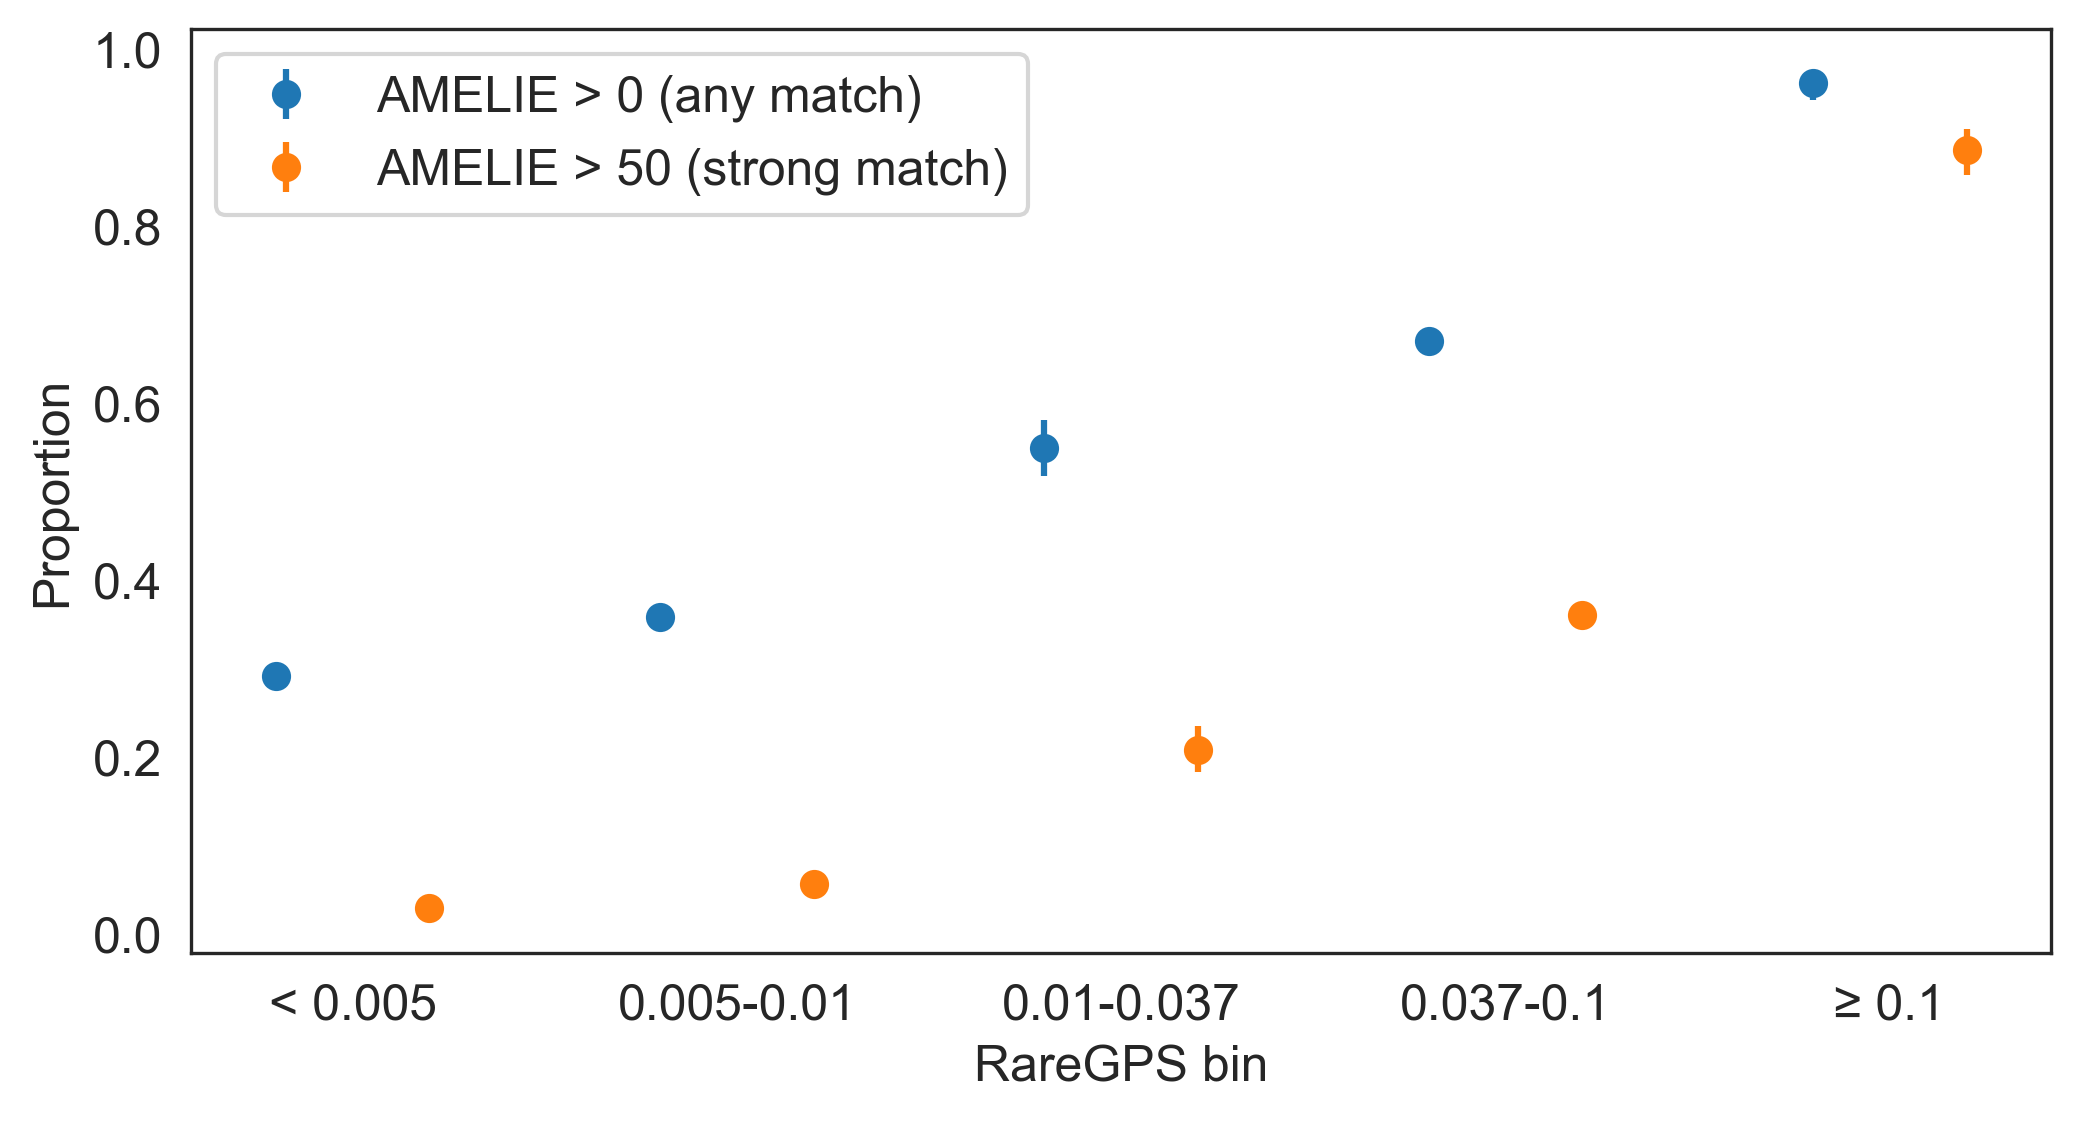

In [4]:
# Creating bins
bins = [0, 0.005, 0.01, cutoff, 0.1, 1]
labels = ['< 0.005', '0.005-0.01', '0.01-0.037', '0.037-0.1', '≥ 0.1']
ap['prediction_bin'] = pd.cut(ap['prediction'], bins=bins, labels=labels, include_lowest=True)

# Calculating Wilson confidence intervals for each bin
results = []
for label in labels:
    bin_data = ap[ap['prediction_bin'] == label]
    n = len(bin_data)
    
    # Proportions for amelie_binary
    count_binary = bin_data['amelie_binary'].sum()
    lower_binary, upper_binary = proportion_confint(count_binary, n, alpha=0.05, method='wilson')
    prop_binary = count_binary / n if n > 0 else np.nan
    
    # Proportions for amelie_binary_strong
    count_binary_strong = bin_data['amelie_binary_strong'].sum()
    lower_strong, upper_strong = proportion_confint(count_binary_strong, n, alpha=0.05, method='wilson')
    prop_binary_strong = count_binary_strong / n if n > 0 else np.nan
    
    results.append({
        'prediction_bin': label,
        'prop_binary': prop_binary, 'lower_binary': lower_binary, 'upper_binary': upper_binary,
        'prop_binary_strong': prop_binary_strong, 'lower_strong': lower_strong, 'upper_strong': upper_strong
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Plotting
plt.figure(figsize=(8, 4), dpi=300)
sns.set_style('white')

unique_bins = np.arange(len(results_df['prediction_bin']))

offset = 0.2  # Adjust this value to control the distance between the error bars

# Error bar for amelie_binary = 1
plt.errorbar(unique_bins - offset, results_df['prop_binary'], 
             yerr=[results_df['prop_binary'] - results_df['lower_binary'], 
                   results_df['upper_binary'] - results_df['prop_binary']], 
             fmt='o', label='AMELIE > 0 (any match)', capsize=0)

# Error bar for amelie_binary_strong = 1
plt.errorbar(unique_bins + offset, results_df['prop_binary_strong'], 
             yerr=[results_df['prop_binary_strong'] - results_df['lower_strong'], 
                   results_df['upper_strong'] - results_df['prop_binary_strong']], 
             fmt='o', label='AMELIE > 50 (strong match)', capsize=0)

plt.xticks(unique_bins, results_df['prediction_bin'])  # Set x-ticks to the string labels
plt.xlabel('RareGPS bin')
plt.ylabel('Proportion')
plt.legend()
